## Customer Usage Template

Welcome to the Customer Usage Analysis Template! This powerful tool is designed to provide you with unparalleled insights into your customers' usage patterns. With just a few simple inputs – an admin user's API Key, contract start and end dates, and your chosen directory name – you can unlock a wealth of valuable information.

<strong>How it Works:</strong>

+ This code uses the reports API to collect summary level daily usage. Each request will capture a 90-day snapshot and auto compile the results into a single data frame. From here the newly formed data frame will be manipulated into a series of visuals that will download to your working direcotry. Each of these visuals will provide you insight into your customer's usage and may even be useful to share with customers directly. 


+ Once you've input the necessary information, you can execute each code block. Keep in mind that the processing time may vary depending on the number of usage reports requested from teh Reports API. On average, each 90-day report takes approximately 1-2 minutes to generate.

With this template, you'll gain deep insights into your customer base, allowing you to make data-driven decisions and optimize your services effectively.

*For questions regarding this code, please message <strong>Austin Stone</strong> on slack.

In [1]:
import requests
import os
from requests.auth import HTTPBasicAuth

# Use an organization admin API key. Must be sitting within the parent organization if you are collecting information about suborgs
os.environ['PL_API_KEY']='' 
PLANET_API_KEY = os.getenv('PL_API_KEY')

# Input the contract and start and end dates
contract_start = "2023-02-01"
contract_end = "2026-01-31"

# Create a directory to save the CSV files
csv_dir = 'UCSB_Usage'
os.makedirs(csv_dir, exist_ok=True)

In [2]:
from datetime import datetime, timedelta

# Define the initial payload
initial_payload = {
    "Report_Type": "summary",
    "Cadence": "daily",
    "SubOrgs": {
        "Include": "all"
    }
}

# Define the start date and end date
start_date = datetime.strptime(contract_start, "%Y-%m-%d")
end_date = datetime.strptime(contract_end, "%Y-%m-%d")

# Define the interval (90 days)
interval = timedelta(days=90)

# Get the current date
current_date = datetime.now()

# Create a list to store payloads
payloads = []

# Create a list to store references to the payload dictionaries
payload_variables = []

# Generate payloads for each 90-day interval
while start_date <= current_date:
    # Calculate the end date for this interval
    interval_end_date = min(start_date + interval, end_date)

    # Create a new payload dictionary for this interval
    payload = initial_payload.copy()

    # Update the payload with the current interval's dates
    payload["Toi"] = {
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": interval_end_date.strftime("%Y-%m-%d")
    }

    # Append the payload to the list of payloads
    payloads.append(payload)

    # Add a reference to the payload dictionary to the list of payload variable names
    payload_variables.append(payload)

    # Move to the next interval
    start_date += interval

payload_variables

[{'Report_Type': 'summary',
  'Cadence': 'daily',
  'SubOrgs': {'Include': 'all'},
  'Toi': {'start_date': '2023-02-01', 'end_date': '2023-05-02'}},
 {'Report_Type': 'summary',
  'Cadence': 'daily',
  'SubOrgs': {'Include': 'all'},
  'Toi': {'start_date': '2023-05-02', 'end_date': '2023-07-31'}},
 {'Report_Type': 'summary',
  'Cadence': 'daily',
  'SubOrgs': {'Include': 'all'},
  'Toi': {'start_date': '2023-07-31', 'end_date': '2023-10-29'}},
 {'Report_Type': 'summary',
  'Cadence': 'daily',
  'SubOrgs': {'Include': 'all'},
  'Toi': {'start_date': '2023-10-29', 'end_date': '2024-01-27'}}]

In [3]:
import time
import json

url = "https://api.planet.com/reports/v0/downloads/suborgs"

# Define the maximum number of retries and the delay between retries (in seconds)
max_retries = 10
retry_delay = 60  # 1 minute

# Function to check the status of response_v2
def check_status():
    response_v2 = requests.request("GET", url_v2, auth=HTTPBasicAuth(PLANET_API_KEY, ''))
    if response_v2.status_code == 200:
        return response_v2.json().get('status')
    else:
        return None

# Loop through the list of payloads and make requests for each one
for idx, payload_var in enumerate(payload_variables):
    # Make the POST request for the current payload
    response = requests.post(
        url,
        auth=HTTPBasicAuth(PLANET_API_KEY, ''),
        json=payload_var
    )
    
    # Check the response status code and handle it as needed
    if response.status_code == 201:
        print(f"Request {idx + 1} successful")
        
        # You can process the response data here if needed
        geojson = response.json()
        response_id = geojson['id']
        url_v2 = "https://api.planet.com/reports/v0/downloads/suborgs" + "/" + response_id
        
        # Implement the retry mechanism to check the status
        for attempt in range(max_retries):
            response_v2 = requests.request("GET", url_v2, auth=HTTPBasicAuth(PLANET_API_KEY, ''))
            status = check_status()

            if status == "COMPLETED":
                print(f"Request {idx + 1} is completed")
                break  # Exit the retry loop

            elif status == "IN_PROGRESS":
                print(f"Request {idx + 1} is in progress (Attempt {attempt + 1})")

            else:
                print(f"Failed to retrieve status for request {idx + 1} (Attempt {attempt + 1})")

            # Wait for the specified delay before the next retry
            time.sleep(retry_delay)
        
        # Check if the status is "COMPLETED" before downloading the CSV
        if status == "COMPLETED":
            geojson_v2 = response_v2.json()
            # Get the download links for the CSV files (assuming they're in 'contents')
            download_links = geojson_v2.get('contents', [])
            
            if download_links:
                # Iterate through each download link and download the CSV files
                for file_idx, download_link in enumerate(download_links):
                    csv_download_url = download_link
                    
                    # Make a request to download the CSV file
                    response_v3 = requests.get(csv_download_url, auth=HTTPBasicAuth(PLANET_API_KEY, ''))
                    
                    if response_v3.status_code == 200:
                        # Get the CSV file content
                        csv_content = response_v3.content
                        
                        # Create a file path to save the CSV file
                        csv_filename = os.path.join(csv_dir, f'result_{idx + 1}_{file_idx + 1}.csv')
                        
                        # Save the CSV file locally
                        with open(csv_filename, 'wb') as csv_file:
                            csv_file.write(csv_content)
                        
                        print(f"CSV file {file_idx + 1} for request {idx + 1} saved as {csv_filename}")
                    else:
                        print(f"Failed to download CSV file {file_idx + 1} for request {idx + 1}")
            else:
                print(f"No CSV files found for request {idx + 1}")
        else:
            print(f"Request {idx + 1} did not complete successfully")
        
    else:
        print(f"Request {idx + 1} failed with status code {response.status_code}")

Request 1 successful
Request 1 is in progress (Attempt 1)
Request 1 is completed
CSV file 1 for request 1 saved as UCSB_Usage\result_1_1.csv
Request 2 successful
Request 2 is in progress (Attempt 1)
Request 2 is completed
CSV file 1 for request 2 saved as UCSB_Usage\result_2_1.csv
Request 3 successful
Request 3 is in progress (Attempt 1)
Request 3 is completed
CSV file 1 for request 3 saved as UCSB_Usage\result_3_1.csv
Request 4 successful
Request 4 is in progress (Attempt 1)
Request 4 is completed
CSV file 1 for request 4 saved as UCSB_Usage\result_4_1.csv


In [4]:
import pandas as pd
import os

# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# Initialize an empty list to store individual dataframes
dataframes = []

# Loop through each CSV file and read it into a dataframe
for csv_file in csv_files:
    csv_path = os.path.join(csv_dir, csv_file)
    df = pd.read_csv(csv_path)
    dataframes.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Now, combined_df contains all the data from your CSV files in a single dataframe
combined_df

,Date,User_Email,Organization_Name,Plan_ID,Item_Type,Download_Area__sqkm_,Quota_Used__sqkm_,footprint
0,2023-02-10,jonjab@ucsb.edu,"E&R University of California, Santa Barbara (C...",709685,PSScene,1627.299485,542.433162,NaN
1,2023-02-13,jonjab@ucsb.edu,"E&R University of California, Santa Barbara (C...",709685,PSScene,2316.580978,772.193659,NaN
2,2023-03-15,jonjab@ucsb.edu,"E&R University of California, Santa Barbara (C...",709685,PSScene,3163.775619,1054.591873,NaN
3,2023-04-11,xiafeizhao@ucsb.edu,Geomorph - UCSB,711691,REOrthoTile,10838.004515,394.427030,NaN
4,2023-04-19,xiafeizhao@ucsb.edu,Geomorph - UCSB,711691,REOrthoTile,540.660014,51.441998,NaN
...,...,...,...,...,...,...,...,...
182,2023-11-02,grit-planetlabs@ucsb.edu,Planet Data Archive,726011,PSScene,9480.880000,3160.290000,NaN
183,2023-11-03,grit-planetlabs@ucsb.edu,Planet Data Archive,726011,PSScene,17065.580000,5688.530000,NaN
184,2023-11-07,grit-planetlabs@ucsb.edu,Planet Data Archive,726011,PSScene,10102.420000,3367.470000,NaN
185,2023-11-08,grit-planetlabs@ucsb.edu,Planet Data Archive,726011,PSScene,8374.250000,2791.420000,NaN


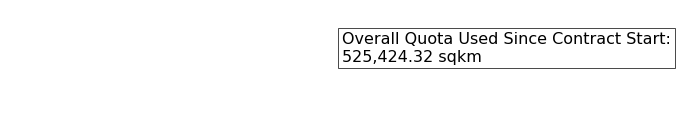

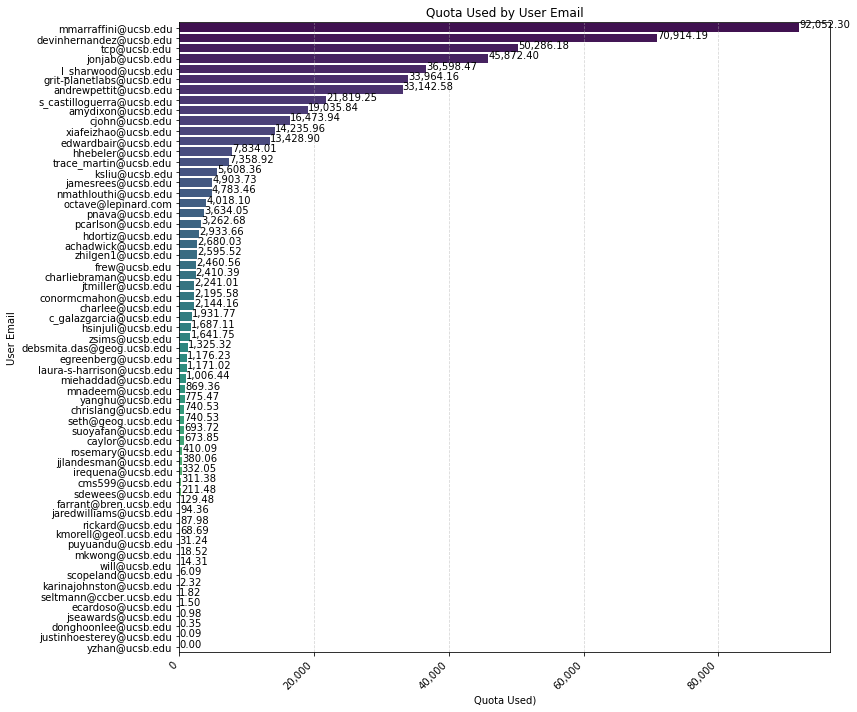

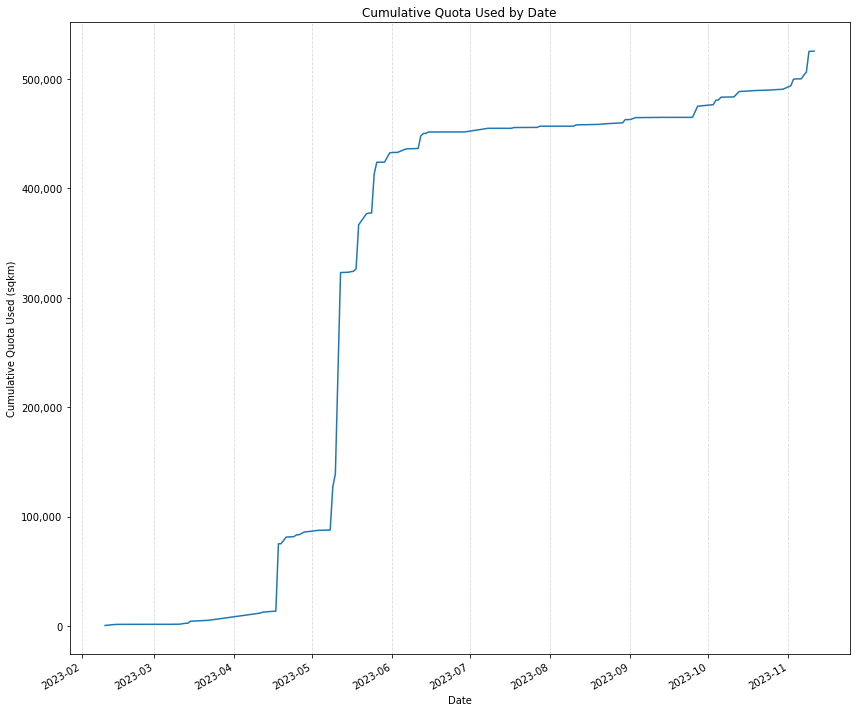

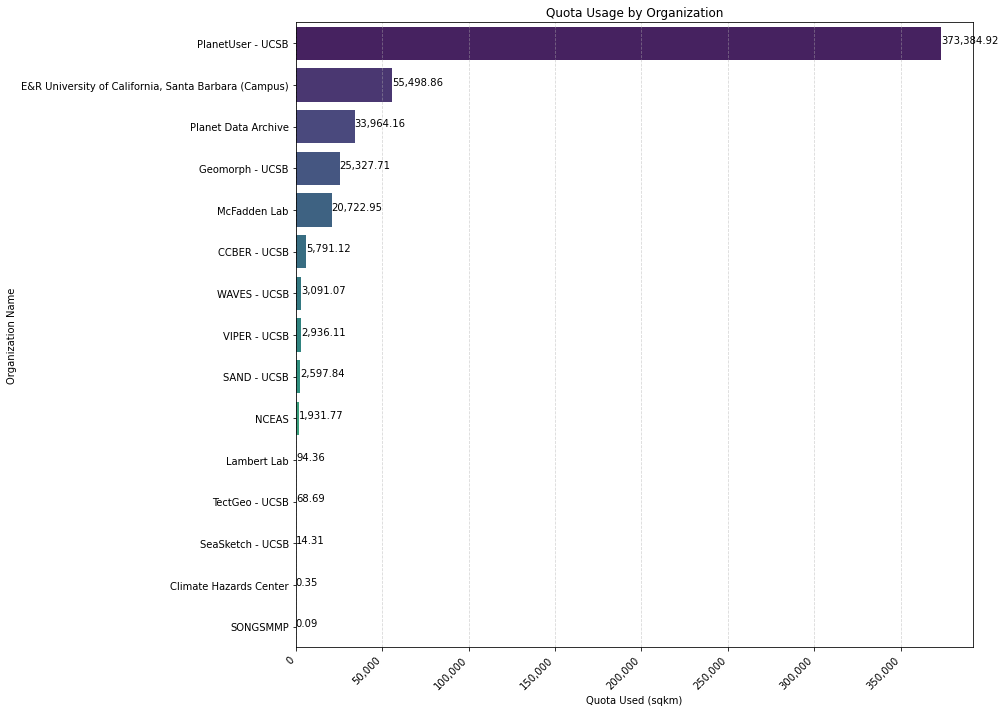

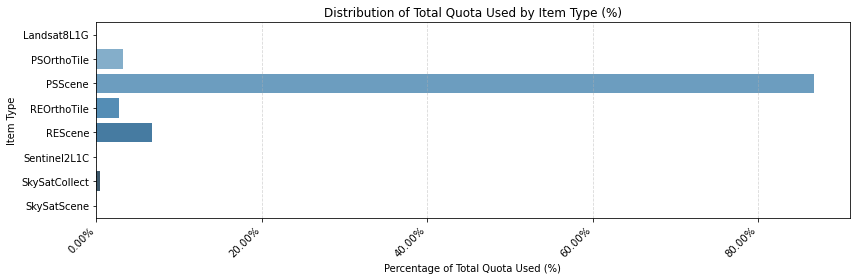

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Convert the 'Date' column to a datetime type
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Calculate the cumulative quota used by date
cumulative_quota_by_date = combined_df.groupby('Date')['Quota_Used__sqkm_'].sum().cumsum()

# Calculate the overall quota used since the first date
overall_quota_used = cumulative_quota_by_date.iloc[-1]  # Get the last value in the cumulative sum

# Display the overall quota used since the first date in a larger font with a professional background
plt.figure(figsize=(12, 2))
plt.text(0.5, 0.5, f"Overall Quota Used Since Contract Start:\n{overall_quota_used:,.2f} sqkm",
         fontsize=16, bbox=dict(facecolor='white', alpha=0.7))
plt.axis('off')
plt.show()

# Group the data by user and sum their quota usage
user_quota_usage = combined_df.groupby('User_Email')['Quota_Used__sqkm_'].sum().reset_index()

# Sort the data by quota used in descending order within each user group
quota_by_user = combined_df.groupby('User_Email')
combined_df_sorted = quota_by_user['Quota_Used__sqkm_'].sum().reset_index().sort_values(by=['Quota_Used__sqkm_'], ascending=False)

# Create a bar plot of quota used by user with custom colors and sorted data
plt.figure(figsize=(12, 10))
ax = sns.barplot(x='Quota_Used__sqkm_', y='User_Email', data=combined_df_sorted, palette="viridis")

# Add data labels to the bars and adjust label position
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.1, p.get_y() + p.get_height() / 2, f'{width:,.2f}', ha="left")

plt.title('Quota Used by User Email')
plt.xlabel('Quota Used)')
plt.ylabel('User Email')
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.grid(True, axis='x', linestyle='--', alpha=0.5)  # Add horizontal grid lines
plt.tight_layout()
output_filepath = os.path.join(csv_dir,'user_quota_usage.png')
plt.savefig(output_filepath, dpi=300)
plt.show()

# Create a line plot of cumulative quota used by date
plt.figure(figsize=(12, 10))
cumulative_quota_by_date.plot()
plt.title('Cumulative Quota Used by Date')
plt.xlabel('Date')
plt.ylabel('Cumulative Quota Used (sqkm)')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
output_filepath = os.path.join(csv_dir,'cumulative_quota_usage.png')
plt.savefig(output_filepath, dpi=300)
plt.tight_layout()


# Group the data by organization and sum their quota usage
org_quota_usage = combined_df.groupby('Organization_Name')['Quota_Used__sqkm_'].sum().reset_index()

# Sort the data by quota usage in descending order within each organization
org_quota_usage_sorted = org_quota_usage.sort_values(by='Quota_Used__sqkm_', ascending=False)

# Create a bar plot to visualize quota usage by organization
plt.figure(figsize=(14, 10))
ax = sns.barplot(x='Quota_Used__sqkm_', y='Organization_Name', data=org_quota_usage_sorted, palette='viridis')

# Add data labels to the bars and adjust label position
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.1, p.get_y() + p.get_height() / 2, f'{width:,.2f}', ha="left")

plt.title('Quota Usage by Organization')
plt.xlabel('Quota Used (sqkm)')
plt.ylabel('Organization Name')
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))  # Format x-axis with commas and 2 decimals
plt.grid(True, axis='x', linestyle='--', alpha=0.5)  # Add horizontal grid lines
plt.tight_layout()
output_filepath = os.path.join(csv_dir, 'org_quota_usage.png')
plt.savefig(output_filepath, dpi=300)
plt.show()

# Calculate the distribution of total quota used by "item_type" as percentages
item_type_distribution = combined_df.groupby('Item_Type')['Quota_Used__sqkm_'].sum() / overall_quota_used * 100

# Create a bar plot to visualize the distribution of total quota used by "item_type"
plt.figure(figsize=(12, 4))
sns.barplot(x=item_type_distribution.values, y=item_type_distribution.index, palette="Blues_d")
plt.title('Distribution of Total Quota Used by Item Type (%)')
plt.xlabel('Percentage of Total Quota Used (%)')
plt.ylabel('Item Type')
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))  # Format x-axis as percentages with 2 decimals
plt.grid(True, axis='x', linestyle='--', alpha=0.5)  # Add horizontal grid lines
plt.tight_layout()

output_filepath = os.path.join(csv_dir, 'item_type_distribution.png')
plt.savefig(output_filepath, dpi=300)

plt.show()
